In [1]:
using Distributions
using Cytof5, Random
using JLD2, FileIO
import StatsBase

In [55]:
using RCall
@rimport mclust
@rimport base as rbase
@rimport stats as rstats
@rimport graphics as rgraphics

In [3]:
# Directory containing CB results 
data_dir = "/scratchdata/alui2/cytof/results/cb/"

# Path to mm1 and best output
path_to_mm0_output = "$(data_dir)/best/output.jld2"
path_to_mm1_output = "$(data_dir)/mm1/output.jld2"
path_to_mm2_output = "$(data_dir)/mm2/output.jld2";

In [4]:
# Get output for miss-mech-0 and miss-mech-1
mm0 = load(path_to_mm0_output)
mm1 = load(path_to_mm1_output)
mm2 = load(path_to_mm2_output)

# Get K from output
K = mm0["c"].K

┌ Warning: type Model.Model.State{Float64} does not exist in workspace; reconstructing
└ @ JLD2 /home/arthur/.julia/packages/JLD2/KjBIK/src/data.jl:1153
┌ Warning: type Model.Model.Constants does not exist in workspace; reconstructing
└ @ JLD2 /home/arthur/.julia/packages/JLD2/KjBIK/src/data.jl:1153
┌ Warning: type Model.Model.##95#96{Int64} does not exist in workspace; reconstructing
└ @ JLD2 /home/arthur/.julia/packages/JLD2/KjBIK/src/data.jl:1153
┌ Warning: type Model.Model.State{Float64} does not exist in workspace; reconstructing
└ @ JLD2 /home/arthur/.julia/packages/JLD2/KjBIK/src/data.jl:1153
┌ Warning: type Model.Model.Constants does not exist in workspace; reconstructing
└ @ JLD2 /home/arthur/.julia/packages/JLD2/KjBIK/src/data.jl:1153
┌ Warning: type Model.Model.##95#96{Int64} does not exist in workspace; reconstructing
└ @ JLD2 /home/arthur/.julia/packages/JLD2/KjBIK/src/data.jl:1153
┌ Warning: type Model.Model.State{Float64} does not exist in workspace; reconstructing
└ @ J

21

In [5]:
# Compute ARI for any two samples
function sample_ari(mcmc1::T, mcmc2::T, i::Integer) where T
  # Number of mcmc samples
  nmcmc = length(mcmc1)

  # Get a pair of mcmc samples
  idx_1, idx_2 = StatsBase.samplepair(nmcmc)
  
  # Compute ARI
  ari = mclust.adjustedRandIndex(
    mcmc1[idx_1][:lam][i],
    mcmc2[idx_2][:lam][i]
  )

  return ari[1]
end

function sample_ari(mcmc1::T, mcmc2::T, i::Integer, nsamps::Integer) where T
  return [sample_ari(mcmc1, mcmc2, i) for _ in 1:nsamps]
end

sample_ari (generic function with 2 methods)

In [6]:
function sample_ari_major(mcmc1::T, mcmc2::T, i::Integer, min_w::Float64) where T
  # Number of mcmc samples
  nmcmc = length(mcmc1)

  # Get a pair of mcmc samples
  idx_1, idx_2 = StatsBase.samplepair(nmcmc)

  # Get W for each mcmc sample
  w_1 = mcmc1[idx_1][:W][i, :]

  # Clusters to keep
  cluster_to_keep = findall(x -> x, w_1 .> min_w)

  # Observations to keep
  idx_keep = findall(cluster_label -> cluster_label in cluster_to_keep,
                     mcmc1[idx_1][:lam][i])
  
  # Compute ARI
  ari = mclust.adjustedRandIndex(
    mcmc1[idx_1][:lam][i][idx_keep],
    mcmc2[idx_2][:lam][i][idx_keep]
  )

  return ari[1]
end

function sample_ari_major(mcmc1::T, mcmc2::T, i::Integer,
                          min_w::Float64, nsamps::Integer) where T
  return [sample_ari_major(mcmc1, mcmc2, i, min_w) for _ in 1:nsamps]
end

sample_ari_major (generic function with 2 methods)

In [7]:
# Get the clusterings from each missing mechanism for sample i
i = 1

# ari_mm0 = sample_ari(mm0["out"][1], mm0["out"][1], i)
# ari_mm0_max = maximum(sample_ari(mm0["out"][1], mm0["out"][1], i, 100))

# mean(sample_ari_major(mm0["out"][1], mm1["out"][1], 1, .1, 100))
# mean(sample_ari_major(mm0["out"][1], mm2["out"][1], 1, .1, 100))

aris_mm0 = sample_ari(mm0["out"][1], mm0["out"][1], i, 100)
aris_mm0_mm1 = sample_ari(mm0["out"][1], mm1["out"][1], i, 100)
aris_mm0_mm2 = sample_ari(mm0["out"][1], mm2["out"][1], i, 100)

println("Mean ARI mm0: $(mean(aris_mm0))")
println("Mean ARI mm0-mm1: $(mean(aris_mm0_mm1))")
println("Mean ARI mm0-mm2: $(mean(aris_mm0_mm2))")

println("Mean ARI mm0-mm1 normalized by ARI mm0: $(mean(aris_mm0_mm1 ./ aris_mm0))")
println("Mean ARI mm0-mm2 normalized by ARI mm0: $(mean(aris_mm0_mm2 ./ aris_mm0))")

Mean ARI mm0: 0.6339210183696793
Mean ARI mm0-mm1: 0.4460741032846993
Mean ARI mm0-mm2: 0.3938706375827097
Mean ARI mm0-mm1 normalized by ARI mm0: 0.7036900827352497
Mean ARI mm0-mm2 normalized by ARI mm0: 0.6213327114987436


In [8]:
ari_mm0_all_methods = Dict(
    :advi => [0.290, 0.144, 0.224],
    :flowsom => [0.201, 0.106, 0.131],
    :mcmc => [0.6344, .5353, .4959]
);

In [9]:
println("ADVI normalized by MCMC ARI (mm0): $(ari_mm0_all_methods[:advi] ./ ari_mm0_all_methods[:mcmc])")
println("ADVI normalized by MCMC ARI (mm0): $(ari_mm0_all_methods[:flowsom] ./ ari_mm0_all_methods[:mcmc])")

ADVI normalized by MCMC ARI (mm0): [0.457125, 0.269008, 0.451704]
ADVI normalized by MCMC ARI (mm0): [0.316835, 0.19802, 0.264166]


In [10]:
function to_onehot(xs, K_max)
    N = length(xs)
    out = zeros(Bool, N, K_max + 1)
    for i in 1:N
        k = xs[i]
        if k == 0
            k = K_max + 1
        end
        out[i, xs[i]] = 1
    end
    out
end
    
# to_onehot([1,3,5], 10)

to_onehot (generic function with 1 method)

In [36]:
# Std of cluster membership for λ₁ in MCMC missing mechanism default.
nmcmc = length(mm0["out"][1])
lam0_i = [mcmc[:lam][i] for mcmc in mm0["out"][1][1:100:nmcmc]]
x = cat([to_onehot(x, K) for x in lam0_i]..., dims=3)
sd_x = dropdims(std(x, dims=3), dims=3)
cor_sd_x = cor(sd_x[:, 1:K])

21×21 Array{Float64,2}:
  1.0         0.17545      0.0378055   …  -0.0657658    -0.0815159 
  0.17545     1.0          0.00136093     -0.0676357    -0.0775388 
  0.0378055   0.00136093   1.0            -0.0466189    -0.0527605 
 -0.044931    0.203637     0.129366        0.0526034    -0.0585295 
 -0.0490467  -0.0416105   -0.0253316       0.00849904   -0.00936723
 -0.0215042  -0.0631837   -0.0489157   …   0.10979       0.0215592 
  0.348228    0.371756     0.309331       -0.124718     -0.107587  
 -0.104216   -0.0110028   -0.069362       -0.0460217     0.0931434 
 -0.0528902  -0.0475697   -0.0304601       0.143708     -0.0438271 
  0.313769    0.0636868   -0.0441015      -0.0350725    -0.0739811 
 -0.146966   -0.117619    -0.0860848   …   0.0662965     0.34306   
 -0.0531795  -0.0514824   -0.0312666      -0.0145324     0.0950197 
  0.145808    0.218104     0.0150171       0.0520586    -0.0743038 
 -0.0708555  -0.0616053   -0.040833       -0.000605729  -0.0210887 
 -0.0294087   0.0427519 

In [52]:
# Hierarchical clustering on distance between sd_x
hc = rstats.hclust(rstats.dist(sd_x'));

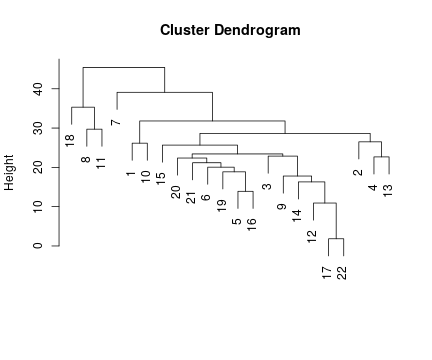

In [77]:
# Plot hclust for the sd of lambda (one-hot)
# Cell types in the same branch are likely
# being confused with one another.
rgraphics.plot(hc, xlab="", sub="");